In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
CANVAS_SIZE = 512

RED_BOX_SIZE = 80
GREEN_BOX_SIZE = 50

RED_START_CENTER = [128, 128]
GREEN_START_CENTER = [128, 400]

TRACKER_MIN_IOU = 0.2
MULTI_MATCH_MIN_IOU = 0.93

TEXT_SIZE_UUID = 0.8

# Generate a canvas

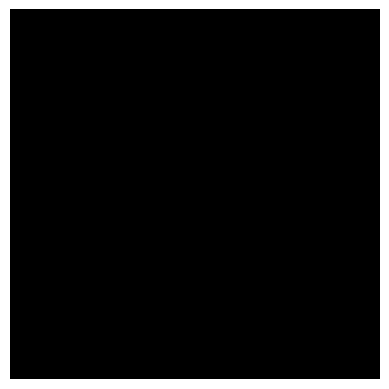

In [3]:
import numpy as np
from scripts.image import show_image_from_ndarray

blank_canvas = np.zeros((CANVAS_SIZE, CANVAS_SIZE, 3), dtype=np.uint8)
show_image_from_ndarray(blank_canvas)

# Define BBoxActor

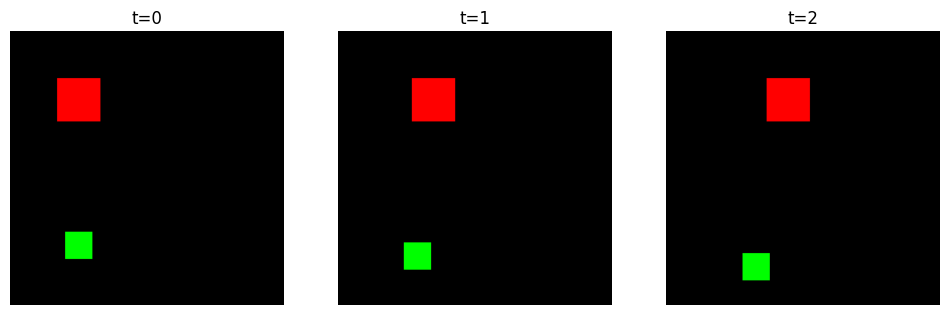

In [4]:
import cv2
from scripts.bbox_actor import BBoxActor
from scripts.image import draw_multiple_image

# Define red and green boxes
red_box = BBoxActor(
    bbox_center_pos=RED_START_CENTER,
    bbox_center_velocity=[50, 0],
    bbox_size=[RED_BOX_SIZE, RED_BOX_SIZE],
    color=(0, 0, 255),
    canvas_size=(CANVAS_SIZE, CANVAS_SIZE),
    noise_std_velocity=[0.0, 0.0],
)

green_box = BBoxActor(
    bbox_center_pos=GREEN_START_CENTER,
    bbox_center_velocity=[20, 20],
    bbox_size=[GREEN_BOX_SIZE, GREEN_BOX_SIZE],
    color=(0, 255, 0),
    canvas_size=(CANVAS_SIZE, CANVAS_SIZE),
    noise_std_velocity=[0.0, 0.0],
)

# Draw red and green boxes
n_sequence = 3
canvas_list = [blank_canvas.copy() for _ in range(n_sequence)]
for t, canvas in enumerate(canvas_list):
    if t > 0:
        red_box.update()
        green_box.update()

    # Drawing red and green boxes
    red_box_xyxy = red_box.get_bbox_info_as_xyxy()
    green_box_xyxy = green_box.get_bbox_info_as_xyxy()
    cv2.rectangle(canvas, red_box_xyxy[:2], red_box_xyxy[2:], red_box.color, thickness=-1)
    cv2.rectangle(canvas, green_box_xyxy[:2], green_box_xyxy[2:], green_box.color, thickness=-1)

image_names = [f"t={t}" for t in range(n_sequence)]
draw_multiple_image(image_names, canvas_list, figsize=(4 * n_sequence, 4))


# Motpy

## Define some boxes

In [5]:
from scripts.bbox_actor import BBoxActor

# Define red and green boxes
red_box = BBoxActor(
    bbox_center_pos=RED_START_CENTER,
    bbox_center_velocity=[10, 0],
    bbox_size=[RED_BOX_SIZE, RED_BOX_SIZE],
    color=(0, 0, 255),
    canvas_size=(CANVAS_SIZE, CANVAS_SIZE),
    noise_std_velocity=[1.0, 0.1],
)

green_box = BBoxActor(
    bbox_center_pos=GREEN_START_CENTER,
    bbox_center_velocity=[2, 0],
    bbox_size=[GREEN_BOX_SIZE, GREEN_BOX_SIZE],
    color=(0, 255, 0),
    canvas_size=(CANVAS_SIZE, CANVAS_SIZE),
    noise_std_velocity=[1.0, 1.0],
)


## Setup a tracker

In [6]:
from motpy import MultiObjectTracker
from motpy.model import ModelPreset
from typing import Dict

model_spec: Dict[str, float] = ModelPreset.constant_acceleration_and_static_box_size_2d.value
model_spec.update({
    "q_var_pos": 100.0,  # represents the variance of the process noise in position, its unit is [pix^2]
    "r_var_pos": 0.1     # represents the variance of the observation noise in position, its unit is [pix^2]
})
tracker = MultiObjectTracker(
    dt=1.0,
    tracker_kwargs={"max_staleness": 5},
    model_spec=model_spec,
    matching_fn_kwargs={"min_iou": TRACKER_MIN_IOU, "multi_match_min_iou": MULTI_MATCH_MIN_IOU},
)


In [7]:
from motpy.core import Box, Detection

def generate_pseudo_detection_result(bbox_actor: BBoxActor) -> Detection:
    box_xyxy: Box = np.asarray(bbox_actor.get_bbox_info_as_xyxy())
    return Detection(box=box_xyxy, score=1.0)

In [8]:
from motpy.core import Track, Detection
from typing import List, Dict, Sequence

# Run tracking
n_sequence = 10
red_box.reset()
green_box.reset()
active_tracks_list = []
dict_actual_bbox_trajectories: Dict[str, List[List[float]]] = {"red": [], "green": []}
for t in range(n_sequence):
    if t > 0:
        red_box.update()
        green_box.update()
    dict_actual_bbox_trajectories["red"].append(red_box.get_bbox_info_as_xyxy())
    dict_actual_bbox_trajectories["green"].append(green_box.get_bbox_info_as_xyxy())

    detection_results: Sequence[Detection] = [generate_pseudo_detection_result(bbox_actor) for bbox_actor in [red_box, green_box]]
    active_tracks: List[Track] = tracker.step(detections=detection_results)
    active_tracks_list.append(active_tracks)
    tracker.cleanup_trackers()


## Summarize tracking information as Tracklet

- The reason of generating Tracklet is shown as below.

- **Consolidation of related frame information**:

    Tracklet objects store the frame indices and corresponding BBOX information related to a specific track. This allows the consolidation and management of information related to a particular tracked object within a single object. It eliminates the need to manage lists or dictionaries for each frame separately to track the boxes held by a track.

- **Easy calculation of track length and typical BBOX size**:

    Tracklet objects store frame indices and BBOX information, enabling easy calculation of statistics such as track length and box size. For example, the track_length method provides the track's length, and the calculate_typical_bbox_size method calculates the typical size of the boxes.

- **Simplified data visualization and analysis**:

    Tracklet objects consolidate related frame information, making data visualization and analysis straightforward. For instance, when plotting the trajectory of a track, you can retrieve the frame indices and corresponding BBOX information from the Tracklet object for plotting purposes.


In [9]:
from scripts.tracklet import Tracklet

dict_uuid_tracklet: Dict[str, Tracklet] = {}
frame_index_uuids_list: List[str] = [[] for _ in range(n_sequence)]
for t in range(n_sequence):
    # Retrieve the list of active tracks for frame t from active_tracks_list[t].
    active_tracks: List[Track] = active_tracks_list[t]
    dict_track_id_bbox_newframe = {track.id: track.box for track in active_tracks}

    # Extract the UUIDs in new_frame_tracklet_uuids that are not present
    # in registered_tracklet_uuids into new_tracklet_uuids, representing newly appeared tracklets.
    registered_tracklet_uuids = list(dict_uuid_tracklet.keys())
    new_frame_tracklet_uuids = list(dict_track_id_bbox_newframe.keys())
    frame_index_uuids_list[t] = list(dict_track_id_bbox_newframe.keys())
    new_tracklet_uuids = np.setdiff1d(new_frame_tracklet_uuids, registered_tracklet_uuids)
    existing_tracklet_uuids = np.setdiff1d(new_frame_tracklet_uuids, new_tracklet_uuids)

    # Create new Tracklet objects for each UUID in new_tracklet_uuids
    # and add the current frame's BBOX information.
    for uuid in new_tracklet_uuids:
        tracklet = Tracklet(uuid)
        tracklet.append_bbox(t, dict_track_id_bbox_newframe[uuid].copy())
        dict_uuid_tracklet[uuid] = tracklet

    # Append the current frame's BBOX information to the corresponding Tracklet for each UUID in existing_tracklet_uuids.
    for uuid in existing_tracklet_uuids:
        dict_uuid_tracklet[uuid].append_bbox(t, dict_track_id_bbox_newframe[uuid].copy())


In [10]:
from functools import reduce


def flatten_list(lst, item):
    if isinstance(item, list):
        return lst + reduce(flatten_list, item, [])
    else:
        return lst + [item]


uniqued_uuid_list = np.unique(reduce(flatten_list, frame_index_uuids_list, []))
tracklet_list: List[Tracklet] = [dict_uuid_tracklet[uuid] for uuid in uniqued_uuid_list]
print(uniqued_uuid_list)


['201b4bc3-d8ac-4473-9f71-73c61dd34050'
 'eedf3340-1e6a-41a1-b46e-92eab2024bec']


In [11]:
import scipy
from motpy.metrics import calculate_iou

# Calculate the typical BBOX size for each tracklet
[tracklet.calculate_typical_bbox_size() for tracklet in tracklet_list]
[tracklet.typical_bbox_size for tracklet in tracklet_list]

# Calculate the cost matrix for matching
initial_bbox_info_red = red_box.bbox_xyxy_init
initial_bbox_info_green = green_box.bbox_xyxy_init
cost_mat = np.zeros((2, len(tracklet_list)))
for i, tracklet in enumerate(tracklet_list):
    initial_bbox_tracklet = tracklet.bbox_dict[tracklet.frame_indices[0]]
    cost_mat[0, i] = calculate_iou(initial_bbox_info_red, initial_bbox_tracklet)
    cost_mat[1, i] = calculate_iou(initial_bbox_info_green, initial_bbox_tracklet)

# Matching via Hungarian algorithm
_, matched_indices = scipy.optimize.linear_sum_assignment(cost_mat, maximize=True)
index_bbox_red = matched_indices[0]
index_bbox_green = matched_indices[1]
red_box_uuid = uniqued_uuid_list[index_bbox_red]
green_box_uuid = uniqued_uuid_list[index_bbox_green]

print(f"uuid(red): {red_box_uuid}")
print(f"uuid(green): {green_box_uuid}")


uuid(red): eedf3340-1e6a-41a1-b46e-92eab2024bec
uuid(green): 201b4bc3-d8ac-4473-9f71-73c61dd34050


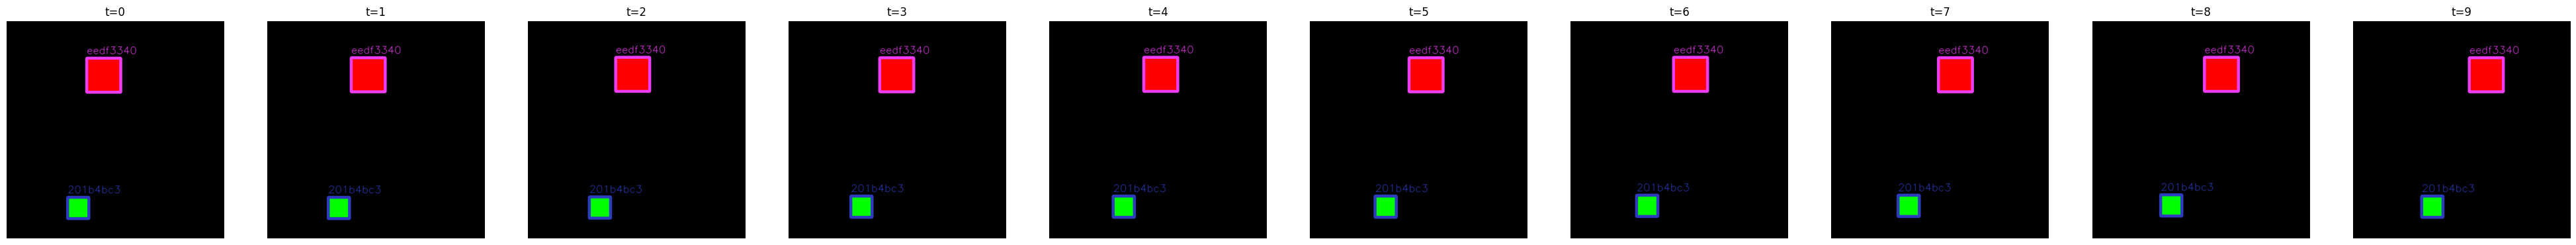

In [12]:
from scripts.image import generate_unique_color


def draw_rectangle_from_bbox_xyxy(canvas, bbox_xyxy, color, filled=True):
    bbox_left_upper = (int(bbox_xyxy[0]), int(bbox_xyxy[1]))
    bbox_right_lower = (int(bbox_xyxy[2]), int(bbox_xyxy[3]))
    if filled:
        cv2.rectangle(canvas, bbox_left_upper, bbox_right_lower, color, -1)
    else:
        cv2.rectangle(canvas, bbox_left_upper, bbox_right_lower, color, 5)


dict_actual_bbox_trajectories["red"].append(red_box.get_bbox_info_as_xyxy())
dict_actual_bbox_trajectories["green"].append(green_box.get_bbox_info_as_xyxy())

# Drawing the trajectories
name_sequence = [f"t={t}" for t in range(n_sequence)]
canvas_sequence = [blank_canvas.copy() for _ in range(n_sequence)]
for t, canvas in enumerate(canvas_sequence):
    red_bbox_xyxy = dict_actual_bbox_trajectories["red"]
    draw_rectangle_from_bbox_xyxy(canvas, red_bbox_xyxy[t], (0, 0, 255))

    green_bbox_xyxy = dict_actual_bbox_trajectories["green"]
    draw_rectangle_from_bbox_xyxy(canvas, green_bbox_xyxy[t], (0, 255, 0))

    # Drawing the tracklets
    for tracklet in tracklet_list:
        tracklet_color = generate_unique_color(tracklet.uuid)
        draw_rectangle_from_bbox_xyxy(canvas, tracklet.bbox_dict[t], tracklet_color, filled=False)

        # Draw the first 8 characters of the UUID
        text_loc = (int(tracklet.bbox_dict[t][0]), max(int(tracklet.bbox_dict[t][1]) - 10, 0))
        cv2.putText(canvas, tracklet.uuid[:8], text_loc, cv2.FONT_HERSHEY_SIMPLEX, TEXT_SIZE_UUID, tracklet_color, 1, cv2.LINE_AA)

draw_multiple_image(name_sequence, canvas_sequence, figsize=(5 * n_sequence, 5))


In [13]:
# Calculate typical center point velocities of each tracklet
[tracklet.calculate_typical_bbox_center_velocity() for tracklet in tracklet_list]

# Printout the typical center point velocities of each tracklet
print("Typical center point velocities of each tracklet")
print(f"red({red_box_uuid}): {tracklet_list[index_bbox_red].typical_bbox_center_velocity}")
print(f"green({green_box_uuid}): {tracklet_list[index_bbox_green].typical_bbox_center_velocity}")


Typical center point velocities of each tracklet
red(eedf3340-1e6a-41a1-b46e-92eab2024bec): (9.020615282500984, -5.039184927113638e-06)
gren(201b4bc3-d8ac-4473-9f71-73c61dd34050): (1.9992847567081071, -0.4992932906738474)
